In [ ]:
pip install gymnasium highway-env torch tensorboard matplotlib


Episode 0: Reward = 19.322741716317697, Steps = 10
Evaluation: Reward = 708.4968826419107, Steps = 351.3333333333333
Episode 1: Reward = 14.518570813785244, Steps = 6
Episode 2: Reward = 22.48926431603471, Steps = 9
Episode 3: Reward = 15.100423509524527, Steps = 6
Episode 4: Reward = 18.65419511419439, Steps = 8
Episode 5: Reward = 40.90889769310294, Steps = 20
Evaluation: Reward = 767.7494159385365, Steps = 380.3333333333333
Episode 6: Reward = 16.99437095449302, Steps = 7
Episode 7: Reward = 6.075939511211532, Steps = 3
Episode 8: Reward = 12.939574753604633, Steps = 6
Episode 9: Reward = 17.072271650957944, Steps = 9
Episode 10: Reward = 51.62601231607313, Steps = 22
Evaluation: Reward = 722.0569925042313, Steps = 356.3333333333333
Episode 11: Reward = 59.58844662433207, Steps = 28
Episode 12: Reward = 46.462492003136575, Steps = 19
Episode 13: Reward = 36.69782682082702, Steps = 13
Episode 14: Reward = 28.163448675166798, Steps = 11
Episode 15: Reward = 10.734821023530987, Steps =

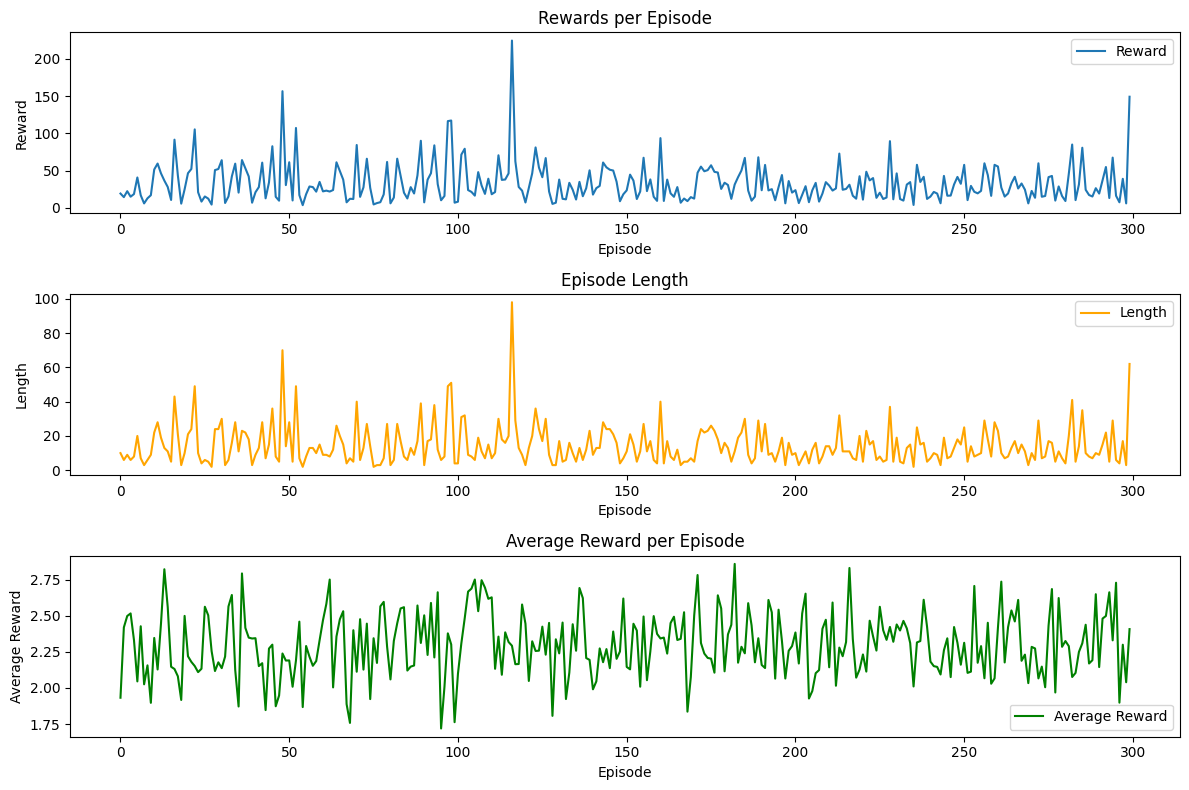

Training complete. TensorBoard logs saved in ./runs/DDPG_experiment


In [4]:
import gymnasium as gym
import highway_env
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import os
import random
from collections import deque

# Set device to CPU
device = torch.device("cpu")

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.buffer)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim[0], hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), dim=-1)  # Use softmax for discrete actions

class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim[0], hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class OUNoise:
    def __init__(self, action_dimension, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return self.state

class DDPGAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=256, lr_actor=1e-3, lr_critic=1e-2):
        self.actor = Actor(state_dim, action_dim, hidden_dim).to(device)
        self.actor_target = Actor(state_dim, action_dim, hidden_dim).to(device)
        self.actor_target.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        self.critic = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic_target = Critic(state_dim, action_dim, hidden_dim).to(device)
        self.critic_target.load_state_dict(self.critic.state_dict())
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)

        self.noise = OUNoise(action_dim)

    def select_action(self, state, add_noise=True):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action_probs = self.actor(state).cpu().data.numpy().flatten()
        if add_noise:
            noise = self.noise.sample()
            action_probs += noise[:len(action_probs)]
        action_probs = np.clip(action_probs, 0, None)
        action_probs_sum = action_probs.sum()
        if action_probs_sum > 0:
            action_probs /= action_probs_sum
        else:
            action_probs = np.ones_like(action_probs) / len(action_probs)
        
        # Ensure the action is within the valid range
        action = np.random.choice(len(action_probs), p=action_probs)
        action = np.clip(action, 0, env.action_space.n - 1)
        return action

    def train(self, replay_buffer, batch_size=32, gamma=0.99, tau=0.005):
        if len(replay_buffer) < batch_size:
            return None, None

        state, action, reward, next_state, done = replay_buffer.sample(batch_size)
        
        state = torch.FloatTensor(state).to(device)
        action = torch.LongTensor(action).to(device)
        reward = torch.FloatTensor(reward).unsqueeze(1).to(device)
        next_state = torch.FloatTensor(next_state).to(device)
        done = torch.FloatTensor(done).unsqueeze(1).to(device)

        # Compute the target Q value
        with torch.no_grad():
            next_action_probs = self.actor_target(next_state)
            target_Q = (next_action_probs * self.critic_target(next_state)).sum(dim=1, keepdim=True)
            target_Q = reward + (gamma * target_Q * (1 - done))

        # Get current Q estimate
        current_Q = self.critic(state)
        action = action.unsqueeze(1)
        current_Q = current_Q.gather(1, action)

        # Compute critic loss
        critic_loss = F.mse_loss(current_Q, target_Q)

        # Optimize the critic
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)
        self.critic_optimizer.step()

        # Compute actor loss
        actor_loss = -(self.critic(state) * self.actor(state)).sum(dim=1).mean()

        # Optimize the actor
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1)
        self.actor_optimizer.step()

        # Update the frozen target models
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        return actor_loss.item(), critic_loss.item()

    def save(self, directory, name):
        torch.save(self.actor.state_dict(), f'{directory}/{name}_actor.pth')
        torch.save(self.critic.state_dict(), f'{directory}/{name}_critic.pth')

    def load(self, directory, name):
        self.actor.load_state_dict(torch.load(f'{directory}/{name}_actor.pth'))
        self.critic.load_state_dict(torch.load(f'{directory}/{name}_critic.pth'))

def calculate_reward(info, collision_penalty=-1.0, speed_reward=0.1, idle_penalty=-0.01):
    reward = 0

    # Check if there was a collision
    if info.get('crashed', False):
        reward += collision_penalty

    # Reward for maintaining speed if speed info is available
    speed = info.get('speed', 0)
    reward += speed_reward * speed

    # Penalize idling if action is 'idle'
    if info.get('action', -1) == 0:  
        reward += idle_penalty

    return reward

def train_ddpg(agent, env, replay_buffer, writer, num_episodes=300, max_timesteps=500, batch_size=32, start_timesteps=5000, eval_freq=5, save_freq=50, model_dir='./models/'):
    total_timesteps = 0
    episode_num = 0
    best_reward = -np.inf

    while episode_num < num_episodes:
        state, _ = env.reset()
        episode_reward = 0
        episode_timesteps = 0
        done = False

        while not done and episode_timesteps < max_timesteps:
            if total_timesteps < start_timesteps:
                action = env.action_space.sample()
            else:
                action = agent.select_action(np.array(state))

            # Step the environment and get the next state and reward info
            next_state, reward, done, _, info = env.step(action)
            reward = calculate_reward(info)

            replay_buffer.add(state, action, reward, next_state, done)

            state = next_state
            episode_reward += reward
            episode_timesteps += 1
            total_timesteps += 1

            if total_timesteps >= start_timesteps:
                actor_loss, critic_loss = agent.train(replay_buffer, batch_size=batch_size)

                # Log training metrics
                if actor_loss is not None and critic_loss is not None:
                    writer.add_scalar('Training/Actor Loss', actor_loss, total_timesteps)
                    writer.add_scalar('Training/Critic Loss', critic_loss, total_timesteps)
                
                writer.add_scalar('Training/Reward', reward, total_timesteps)

        # Log episode metrics
        writer.add_scalar('Episode/Reward', episode_reward, episode_num)
        writer.add_scalar('Episode/Length', episode_timesteps, episode_num)
        writer.add_scalar('Episode/Average Reward', episode_reward / episode_timesteps, episode_num)
        print(f"Episode {episode_num}: Reward = {episode_reward}, Steps = {episode_timesteps}")

        # Evaluation and visualization
        if episode_num % eval_freq == 0:
            eval_reward, eval_steps = evaluate_policy(env, agent)
            writer.add_scalar('Evaluation/Reward', eval_reward, episode_num)
            writer.add_scalar('Evaluation/Steps', eval_steps, episode_num)
            writer.add_scalar('Evaluation/Average Reward', eval_reward / eval_steps, episode_num)
            print(f"Evaluation: Reward = {eval_reward}, Steps = {eval_steps}")

            # Save best model
            if eval_reward > best_reward:
                best_reward = eval_reward
                agent.save(model_dir, "best_model")

        # Save model periodically
        if episode_num % save_freq == 0:
            agent.save(model_dir, f"model_episode_{episode_num}")

        episode_num += 1

    writer.close()
    env.close()

def evaluate_policy(env, agent, eval_episodes=3):
    avg_reward = 0.
    avg_steps = 0.
    for _ in range(eval_episodes):
        state, _ = env.reset()
        done = False
        steps = 0
        while not done:
            action = agent.select_action(np.array(state), add_noise=False)
            state, reward, done, _, info = env.step(action)
            avg_reward += calculate_reward(info)
            steps += 1

        avg_steps += steps
    avg_reward /= eval_episodes
    avg_steps /= eval_episodes
    return avg_reward, avg_steps

def plot_metrics(log_dir):
    import matplotlib.pyplot as plt
    from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

    event_acc = EventAccumulator(log_dir)
    event_acc.Reload()

    # Extract metrics
    rewards = event_acc.Scalars('Episode/Reward')
    lengths = event_acc.Scalars('Episode/Length')
    avg_rewards = event_acc.Scalars('Episode/Average Reward')

    # Plot metrics
    fig, ax = plt.subplots(3, 1, figsize=(12, 8))

    ax[0].plot([x.step for x in rewards], [x.value for x in rewards], label='Reward')
    ax[0].set_title('Rewards per Episode')
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Reward')
    ax[0].legend()

    ax[1].plot([x.step for x in lengths], [x.value for x in lengths], label='Length', color='orange')
    ax[1].set_title('Episode Length')
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('Length')
    ax[1].legend()

    ax[2].plot([x.step for x in avg_rewards], [x.value for x in avg_rewards], label='Average Reward', color='green')
    ax[2].set_title('Average Reward per Episode')
    ax[2].set_xlabel('Episode')
    ax[2].set_ylabel('Average Reward')
    ax[2].legend()

    plt.tight_layout()
    plt.savefig("training_metrics.png")
    plt.show()

if __name__ == "__main__":
    # Initialize environment without render mode
    env = gym.make("highway-v0")
    state_dim = env.observation_space.shape
    action_dim = env.action_space.n

    # Initialize agent and replay buffer
    agent = DDPGAgent(state_dim, action_dim)
    replay_buffer = ReplayBuffer(capacity=1000000)

    # TensorBoard log directory
    log_dir = './runs/DDPG_experiment'
    os.makedirs(log_dir, exist_ok=True)
    writer = SummaryWriter(log_dir)

    # Model save directory
    model_dir = './models'
    os.makedirs(model_dir, exist_ok=True)

    # Train the agent
    train_ddpg(agent, env, replay_buffer, writer, model_dir=model_dir)

    # Plot metrics after training
    plot_metrics(log_dir)

    print(f"Training complete. TensorBoard logs saved in {log_dir}")


### EVALUATION

Episode 1: Reward = 345.3339706565514, Steps = 526
Episode 2: Reward = 352.5101392900103, Steps = 533
Episode 3: Reward = 349.59712366319627, Steps = 537
Episode 4: Reward = 349.2671308390158, Steps = 525
Episode 5: Reward = 343.149568529492, Steps = 537
Episode 6: Reward = 73.69245569764178, Steps = 102
Episode 7: Reward = 338.1350594921172, Steps = 508
Episode 8: Reward = 1.8832009060624928, Steps = 3
Episode 9: Reward = 25.22748121784616, Steps = 36
Episode 10: Reward = 344.68367303176535, Steps = 562


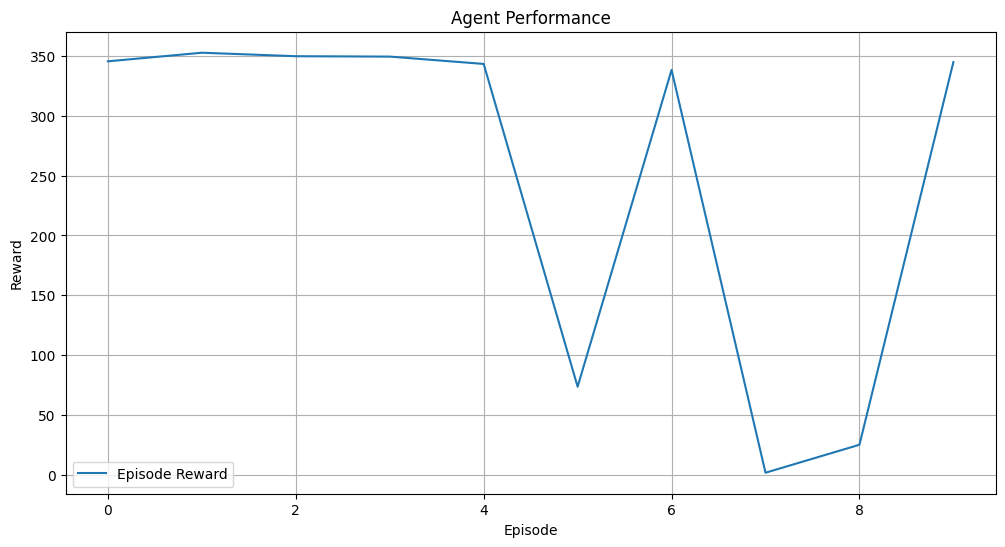

In [6]:
import gymnasium as gym
import highway_env
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set device to CPU
device = torch.device("cpu")

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim[0], hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), dim=-1)  # Use softmax for discrete actions

class DDPGAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        self.actor = Actor(state_dim, action_dim, hidden_dim).to(device)

    def select_action(self, state, add_noise=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action_probs = self.actor(state).cpu().data.numpy().flatten()
        action_probs = np.clip(action_probs, 0, None)
        action_probs_sum = action_probs.sum()
        if action_probs_sum > 0:
            action_probs /= action_probs_sum
        else:
            action_probs = np.ones_like(action_probs) / len(action_probs)
        
        # Ensure the action is within the valid range
        action = np.random.choice(len(action_probs), p=action_probs)
        action = np.clip(action, 0, env.action_space.n - 1)
        return action

    def load(self, directory, name):
        self.actor.load_state_dict(torch.load(f'{directory}/{name}_actor.pth', map_location=device))

def evaluate_agent(agent, env, num_episodes=10, max_steps=1000):
    rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        steps = 0
        done = False

        while not done and steps < max_steps:
            action = agent.select_action(state, add_noise=False)
            state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            steps += 1

        rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward}, Steps = {steps}")

    return rewards

def plot_performance(rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Episode Reward')
    plt.title('Agent Performance')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Initialize environment
    env = gym.make("highway-v0", render_mode='rgb_array')
    state_dim = env.observation_space.shape
    action_dim = env.action_space.n

    # Initialize agent
    agent = DDPGAgent(state_dim, action_dim)

    # Load trained model
    model_dir = './models'
    agent.load(model_dir, 'best_model')

    # Evaluate the agent
    rewards = evaluate_agent(agent, env)

    # Plot the performance
    plot_performance(rewards)


In [ ]:
import gymnasium as gym
import highway_env
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Set device to CPU
device = torch.device("cpu")

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim[0], hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), dim=-1)  # Use softmax for discrete actions

class DDPGAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=256):
        self.actor = Actor(state_dim, action_dim, hidden_dim).to(device)

    def select_action(self, state, add_noise=False):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            action_probs = self.actor(state).cpu().data.numpy().flatten()
        action_probs = np.clip(action_probs, 0, None)
        action_probs_sum = action_probs.sum()
        if action_probs_sum > 0:
            action_probs /= action_probs_sum
        else:
            action_probs = np.ones_like(action_probs) / len(action_probs)
        
        # Ensure the action is within the valid range
        action = np.random.choice(len(action_probs), p=action_probs)
        action = np.clip(action, 0, env.action_space.n - 1)
        return action

    def load(self, directory, name):
        self.actor.load_state_dict(torch.load(f'{directory}/{name}_actor.pth', map_location=device))

def evaluate_agent(agent, env, num_episodes=10, max_steps=1000, render_steps=100):
    rewards = []
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_reward = 0
        steps = 0
        done = False

        while not done and steps < max_steps:
            action = agent.select_action(state, add_noise=False)
            state, reward, done, _, _ = env.step(action)
            episode_reward += reward
            steps += 1

            # Render the environment for up to `render_steps` steps
            if steps <= render_steps:
                img = env.render()
                plt.imshow(img)
                plt.axis('off')
                display(plt.gcf())
                clear_output(wait=True)

        rewards.append(episode_reward)
        print(f"Episode {episode + 1}: Reward = {episode_reward}, Steps = {steps}")

    return rewards

def plot_performance(rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Episode Reward')
    plt.title('Agent Performance')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Initialize environment with render mode
    env = gym.make("highway-v0", render_mode='rgb_array')
    state_dim = env.observation_space.shape
    action_dim = env.action_space.n

    # Initialize agent
    agent = DDPGAgent(state_dim, action_dim)

    # Load trained model
    model_dir = './models'
    agent.load(model_dir, 'best_model')  

    # Evaluate the agent
    rewards = evaluate_agent(agent, env, render_steps=100)

    # Plot the performance
    plot_performance(rewards)
